# ProductNet: Categorize products using image(s) and text descriptors
## Jen Sheng Wong and Kartik Nanda (Cohort 14)
Based on following paper: https://arxiv.org/pdf/1904.09037.pdf

## Problem Statement:
Relates primarily to products on retail/marketplace sites such as Amazon. The problem deals with 3 main aspects:
* Trying to categorize products. Number of categories ~5700 (using the Google taxonomy: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/taxonomy-with-ids.en-US.xls)
* Product has images (1 or more)
* Product has text - title, description, keywords

Possible end-problems to solve: 
a) Find the category, given product images and user provided text description. 
b) Find mis-categorized products

---

## Dataset: 
Products for sale on Amazon; product details from 1996 through 2014, by Prof. McAuley at UCSD
Citations:
* R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
* J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

---

## Dataset Storage:
* Used Google storage bucket located at gs://platform-ai-research/datasets/ProductNet/
* Also used Jen Sheng's Google Drive for intermediate files, images etc

---

## Approaches
### Approach in Paper
The paper assumes that the dataset is unlabeled, and uses the product images in conjunction with the text descriptors (title, keywords, description) to generate a label. It uses an iterative process that includes a master model and a local model. The master model predicts the categories from the images and text. The local model is used to find similar products (possibly using the activations from the master model). These products are then manually labeled. Once a few labels are generated, the set is again fed to the master model, and the process repeats. 

The paper reports having labeled 178000 products across 3900 categories (approx 40 to 60 products per category/label). The prediction accuracy of the master model on the labeled data is 94.7%

### Our Challenges, and Approaches
* Do not have access to the labeled dataset the authors used. So we cannot reproduce the accuracy they have reported on their dataset.
* The first challenge was to create a dataset. Downloaded one of products on Amazon (see citations above) from UCSD. The dataset has product images, title, description,  and categories. 

#### First Approach: use categories column as labels
Our first approach was to use the categories as the label, however, soon realised that it isn't. For one there are roughly 90,000 unique entries. And second, a more detailed examination reveals these are actually key words. Accuracy on a narrower dataset (142 classes) was ~3% 

#### Second Appraoch: similar to the paper's authors' approach
Like the authors, our data is also unlabeled. We have images, and text descriptors. One possible approach is to reproduce the paper's work, namely create a labeled dataset. We could build a text model + image model as the master, and use Platform.ai for labeling and to find similar products (the local model). Used iteratively, this could be used to label enough products to build a robust model. 

Issues with this approach: 
The main issue is Platform.ai does not currently support text.

#### Third Appraoch: generate labels from categories using text mapping
Generate labels from only the text descriptors. We used the categories (key words) entries to generate a label for the product. The labels are from the Google taxonomy (same as used in the paper). The file is stored in the GS bucket. 

We used the Universal Sentence Encoder (USE) to map the category description to a label (minimal distance between the encodings). This was done for the entire 5.5 million dataset. 

For this try, we did not map to the leaf node (~5700 leaf nodes in the google taxo label doc). Instead, mapped to level 2 (shallower) - this provides fewer classes but inconsistent depth (so its not perfect). We got 142 labels. 

#### Fourth Approach: generate labels in Platform.ai
We took a smaller set of 1440 images from 10 categories (labels). The labels were arbitrarily picked from the 20k dataset (142 categories), based on the assigned category/ labels. This is not a clean dataset because there are many mis-labled images in the 20k dataset 

---

## Next steps
1. Increase number of classes, reduce number of samples to increase difficulty for model.
2. Try unfreezing last two layers.
3. Try augmentations.

In [0]:
# from google.colab import files
# files.upload()

# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# # List out all the files in the directory (Make sure that we are logged in)
# gs_path = 'platform-ai-research/datasets/ProductNet/'
# !gsutil ls gs://{gs_path}

In [0]:
# make a dir
!mkdir images_78

In [3]:
# pull
gs_path = 'platform-ai-research/datasets/ProductNet/'
local_path = 'images_78/'

file_name = 'images_cleaned_78classes.zip'

remote_file = gs_path + file_name
local_file = local_path + file_name

!gsutil -m cp -r gs://{remote_file} {local_file}

Copying gs://platform-ai-research/datasets/ProductNet/images_cleaned_78classes.zip...
\ [1/1 files][ 37.3 MiB/ 37.3 MiB] 100% Done                                    
Operation completed over 1 objects/37.3 MiB.                                     


In [0]:
!ls

import os
os.chdir('images_78')

!unzip images_cleaned_78classes.zip
!ls

In [8]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast

import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

from collections import OrderedDict
import torch
import torchvision
import torchvision.models
from torchvision.models import *
from torch.utils import model_zoo

     |████████████████████████████████| 48.5MB 83.0MB/s 


## Setup the Google Storage Bucket for images, df datasets etc
Download relevant files from here into the CoLab working space

## Training
Using ResNet34 with pretrained coefficients, on 777 images spread over 10 classes downloaded from Platform.ai
These classes are labeled by humans (Jen and Kartik)

Edit: The following labels are generated by platform.ai.

In [18]:
os.chdir('../')

!ls

adc.json  images_78  sample_data


In [0]:
np.random.seed(40)
tfms = get_transforms()  #(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

path = 'images_78'

src = (ImageList.from_folder(path)
                   .split_by_rand_pct()
                   .label_from_folder()
                   .transform(tfms, size=224)
                   .databunch())

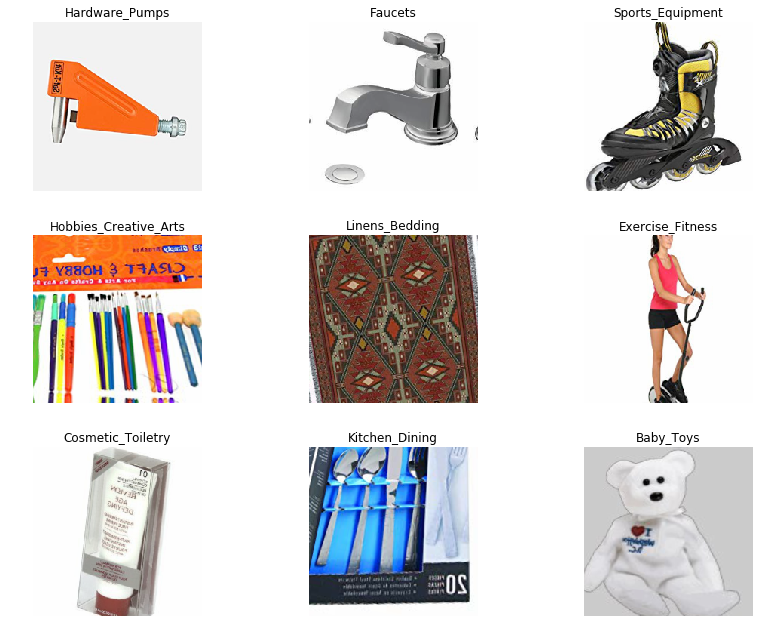

In [23]:
src.show_batch(rows=3, figsize=(12,9))

In [24]:
print(len(src.classes),src.c)
print(len(src.train_ds), len(src.valid_ds), len(src.train_ds)+len(src.valid_ds))

78 78
2777 694 3471


Here, I explore the [paper](https://openreview.net/pdf?id=Bygh9j09KX), *ImageNet-trained CNNs are biased towards texture; increasing shape bias improves accuracy and robustness*.

The authors provided the pretrained ResNet50 further trained on style transfer.

In [0]:
x = 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar'

def custom_resnet(pretrained=False):
    model = torchvision.models.resnet50(pretrained=pretrained)
    model = torch.nn.DataParallel(model).cuda()    
    checkpoint = model_zoo.load_url(x)    
    model.load_state_dict(checkpoint["state_dict"])
    
    model = model.module
    
    all_layers = list(model.children())    
        
    return nn.Sequential(*all_layers)

In [26]:
learn=None
learn = cnn_learner(src, 
                    base_arch=models.resnet34,
                    pretrained=True,
                    metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 106307954.51it/s]


In [27]:
gc.collect()

15974

In [0]:
# learn.layer_groups
# learn.split(lambda m: (m[0][6], m[0][7], m[1]))
# learn.layer_groups

In [29]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.817289,3.982956,0.871758,00:26
1,3.980898,3.072999,0.707493,00:25
2,3.260138,2.809484,0.649856,00:27
3,2.734103,2.680519,0.629683,00:25
4,2.350720,2.691967,0.631124,00:27
5,2.019364,2.688734,0.636888,00:26
6,1.803237,2.688837,0.631124,00:25
7,1.602217,2.696420,0.635447,00:26
8,1.444736,2.699559,0.631124,00:27
9,1.368505,2.694529,0.629683,00:25


In [0]:
learn.save('classes_78_before_')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(src.valid_ds)==len(losses)==len(idxs)

True

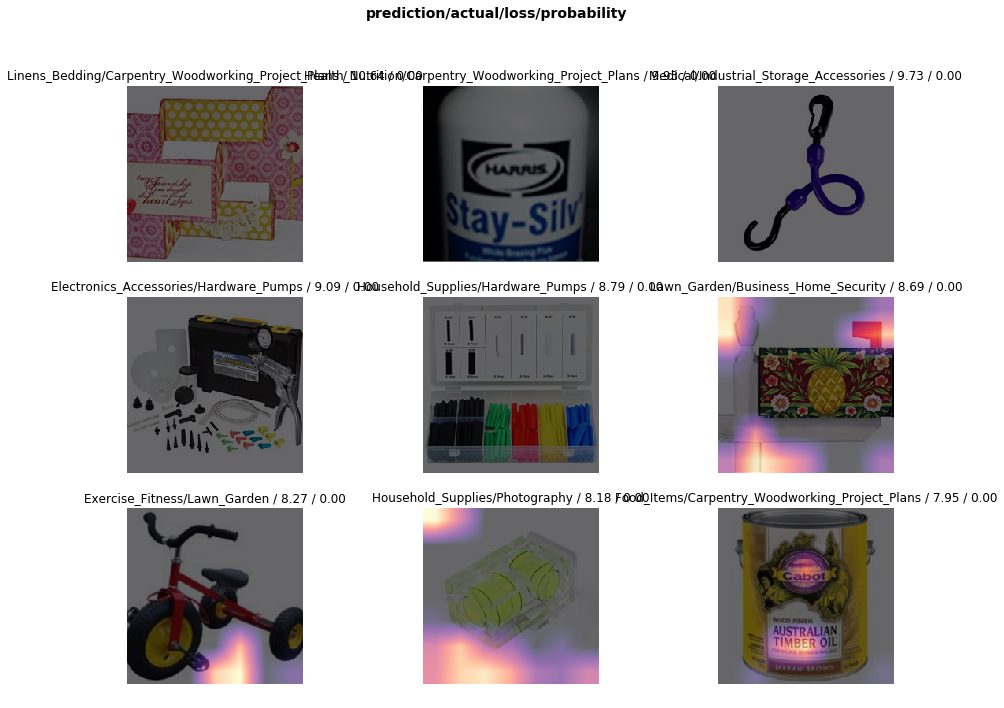

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

In [33]:
# learn.load('stg_2')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


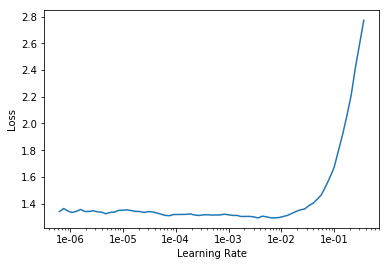

In [34]:
learn.recorder.plot()

In [35]:
# learn.load('stg_2')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.474346,2.892523,0.651297,00:26
1,2.025387,5.127525,0.853026,00:28
2,2.810310,4.657011,0.844380,00:28
3,2.926107,4.301553,0.837176,00:27
4,2.709280,3.637377,0.763689,00:26
5,2.341029,3.218291,0.727666,00:28
6,1.903135,3.081049,0.680115,00:26
7,1.438398,2.970128,0.661383,00:26
8,1.071370,2.937867,0.649856,00:28
9,0.830774,2.934705,0.644092,00:26


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

In [37]:
interp.most_confused(min_val=2)

[('Clothing', 'Beds_Accessories', 4),
 ('Work_Safety_Protective_Gear', 'Sports_Equipment', 4),
 ('Bathroom_Accessories', 'Jewelry_Cleaning_Care', 3),
 ('GPS_Accessories', 'Electronics_Accessories', 3),
 ('Household_Supplies', 'Food_Items', 3),
 ('Music_Sound_Recordings', 'DVDs_Videos', 3),
 ('Sports_Equipment', 'Work_Safety_Protective_Gear', 3),
 ('Baby_Care', 'Baby_Toys', 2),
 ('Baby_Daipers', 'Handbag_Wallet', 2),
 ('Book_Accessories', 'Mobile_Phone_Cases', 2),
 ('Cabinets_Storage', 'Baby_Toddler_Furniture', 2),
 ('Camera_Optic_Accessories', 'Video_Cameras', 2),
 ('Computers', 'Book_Accessories', 2),
 ('DVDs_Videos', 'Computers', 2),
 ('Dentistry', 'Hobbies_Creative_Arts', 2),
 ('Electronics_Accessories', 'Cosmetic_Toiletry', 2),
 ('Electronics_Accessories', 'Power_Electrical_Supplies', 2),
 ('Food_Items', 'Exercise_Fitness', 2),
 ('Food_Items', 'Health_Nutrition', 2),
 ('Hairdressing_Cosmetology', 'Jewelry_Cleaning_Care', 2),
 ('Hardware_Accessories', 'Office_Equipment', 2),
 ('Hobb

In [0]:
# learn.load('stg_2')
# learn.fit_one_cycle(8, max_lr=slice(3e-6,1e-3))

In [39]:
tta_mod = []
for i in np.arange(0.9, 1.3, 0.08):
   tta_mod.append((i, accuracy(*learn.TTA(scale=i))))

In [40]:
sorted(tta_mod, key=lambda e:e[1], reverse=True)

[(0.9, tensor(0.3545)),
 (1.2199999999999998, tensor(0.3530)),
 (1.06, tensor(0.3501)),
 (1.14, tensor(0.3501)),
 (0.98, tensor(0.3487))]